In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.feynnet

In [3]:
module

/store/user/ekoenig/8BAnalysis/NTuples/2018/feynnet
   Background
   NMSSM_XYY_YToHH_8b
   Run2_UL

In [4]:
# signal = ObjIter([])
signal = ObjIter([Tree(f, report=False, altfile='split_0_reweight_eightb_train_{base}') for f in tqdm(module.feynnet_signal_list)])

100%|██████████| 33/33 [00:22<00:00,  1.44it/s]


In [5]:
f_bkg = f'{module.path}/Background/ntuple.root'
bkg = ObjIter([Tree(f_bkg, altfile='split_0_reweight_train_{base}')])


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


In [6]:
(signal + bkg).apply(lambda t : t.extend(scale=t.dataset_norm_abs_scale))

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

100%|██████████| 1/1 [00:09<00:00,  9.68s/it]


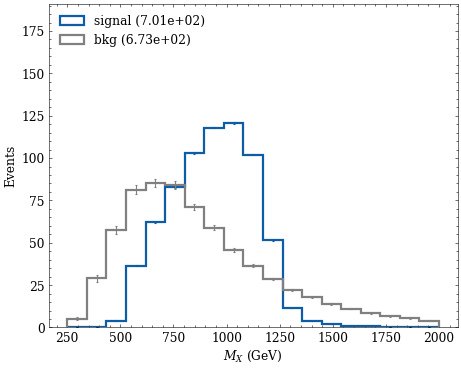

In [7]:
study.quick_region(
    signal, bkg,
    legend=True,
    label=['signal', 'bkg'],
    h_color=[None, 'grey'],
    scale=lambda t : 1/33 if t.is_signal else 1,
    varlist=['X_m'],
    binlist=[(250,2000,20)],
    lumi=None,
)

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


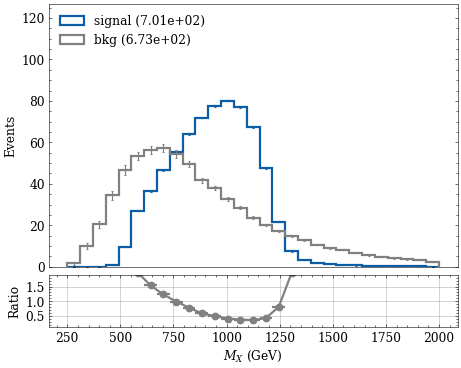

In [8]:
store = obj_store()
study.quick_region(
    signal, bkg,
    legend=True,
    label=['signal', 'bkg'],
    h_color=[None, 'grey'],
    scale=lambda t : 1/33 if t.is_signal else 1,
    varlist=['X_m'],
    binlist=[(250,2000,30)],
    lumi=None,

    ratio=True, r_inv=True, r_store=store,
)

sig_ratio = store[0][0]

In [9]:
sig_sf = Histo.from_graph(sig_ratio)

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


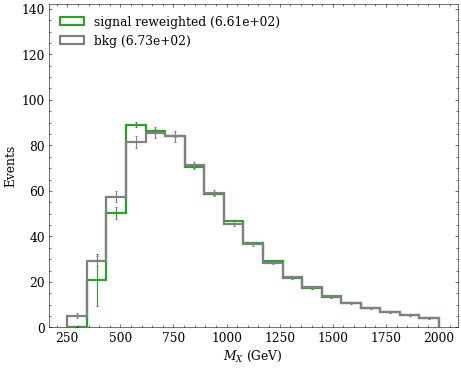

In [10]:
study.quick_region(
    signal, bkg,
    legend=True,
    label=['signal reweighted', 'bkg'],
    h_color=['tab:green', 'grey'],
    scale=lambda t : 1/33 * sig_sf.evaluate(t.X_m) if t.is_signal else 1,
    varlist=['X_m'],
    binlist=[(250,2000,20)],
    lumi=None,
)

In [11]:
signal.apply(lambda t : eightb.load_true_assignment(t), report=True, parallel=True )

100%|██████████| 33/33 [00:19<00:00,  1.68it/s]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [12]:
bkg.apply(lambda t : eightb.load_random_assignment(t, tag='true'), report=True, parallel=True )

100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


[None]

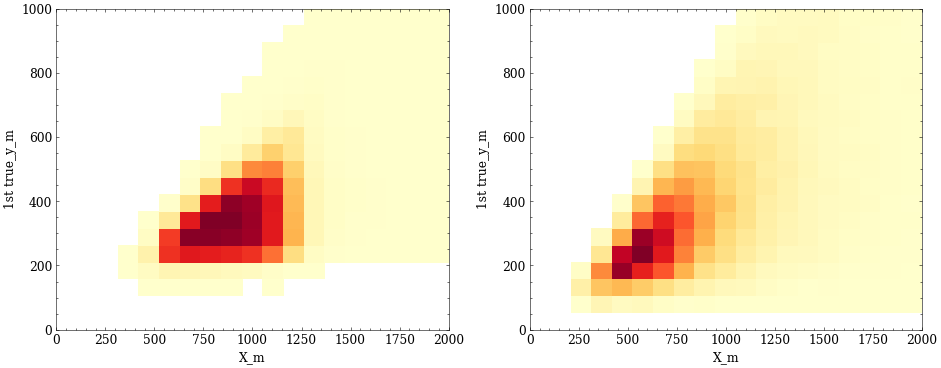

In [13]:
store = obj_store()
study.quick2d_region(
    signal, bkg,
    varlist=['X_m','true_y_m[:,0]'],
    scale=[lambda t : 1/33 ]*33,
    binlist=[(0,2000,20),(0,1000,20)],
    store=store
)

In [14]:
sig_mxmy = store[0][0]
bkg_mxmy = store[1][0]

In [15]:
from utils.plotUtils.graph2d import Ratio2D

In [59]:
def min_count_histo2d(self, min_count=1):
    counts = self.raw_counts
    z = self.histo2d
    zerr = self.error2d

    z[counts < min_count] = 0
    zerr[counts < min_count] = 0

    return self

In [67]:
min_count_histo2d(sig_mxmy, min_count=0)
min_count_histo2d(bkg_mxmy, min_count=0)

In [68]:
ratio = Ratio2D(sig_mxmy, bkg_mxmy, inv=True)
ratio = Histo2D.from_graph2d(ratio)

In [69]:
ratio.evaluate(1200, 250)

array([0.3087514])

100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


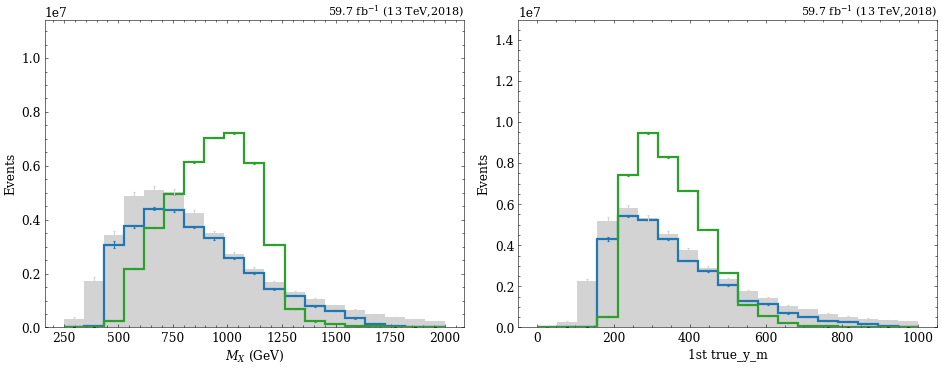

In [70]:
study.quick_region(
    signal, signal, bkg,
    label=['signal','signal reweighted', 'bkg'],
    h_color=['tab:blue','tab:green', 'lightgrey'],
    h_histtype=['step','step','stepfilled'],
    varlist=['X_m','true_y_m[:,0]'],
    scale=[lambda t : 1/33 * ratio.evaluate(t.X_m, t.true_y_m[:,0], nan=1) ]*33 + [lambda t : 1/33]*33,
    binlist=[(250,2000,20),(0,1000,20)],
)

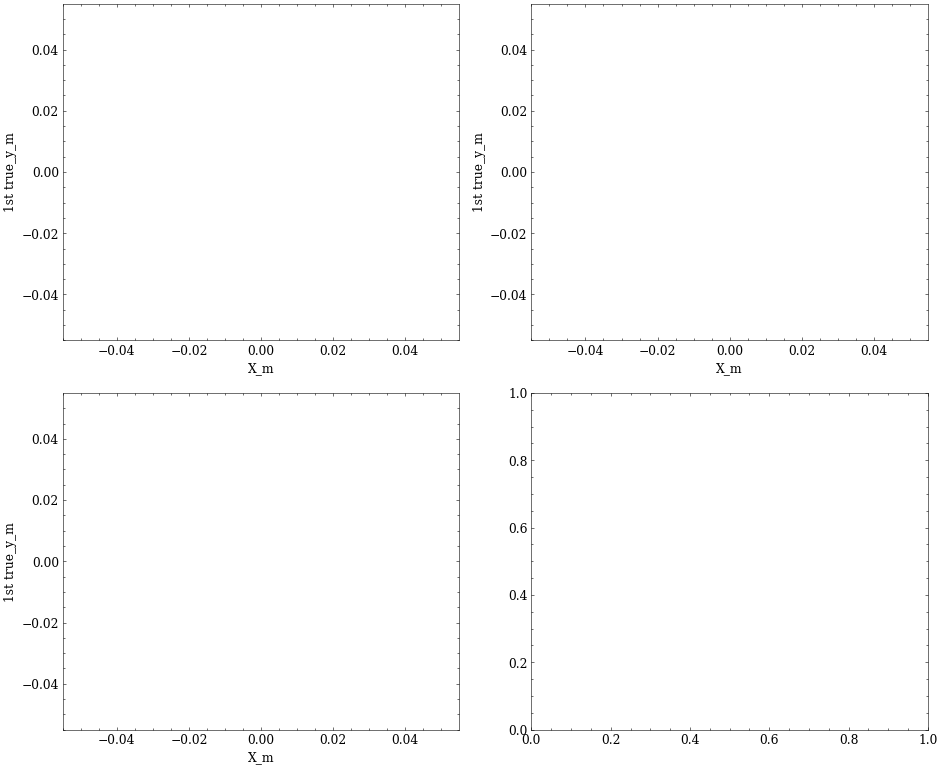

In [71]:
study.quick2d_region(
    signal, signal, bkg,
    label=['signal','signal reweighted', 'bkg'],
    h_color=['tab:blue','tab:green', 'lightgrey'],
    h_histtype=['step','step','stepfilled'],
    varlist=['X_m','true_y_m[:,0]'],
    scale=[lambda t : 1/33 * ratio.evaluate(t.X_m, t.true_y_m[:,0], nan=1) ]*33 + [lambda t : 1/33]*33,
    binlist=[(250,2000,20),(0,1000,20)],
)

array(0.70476036)

In [43]:
ratio = Ratio2D(bkg_mxmy, sig_mxmy)

ValueError: operands could not be broadcast together with shapes (19,) (361,) 

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


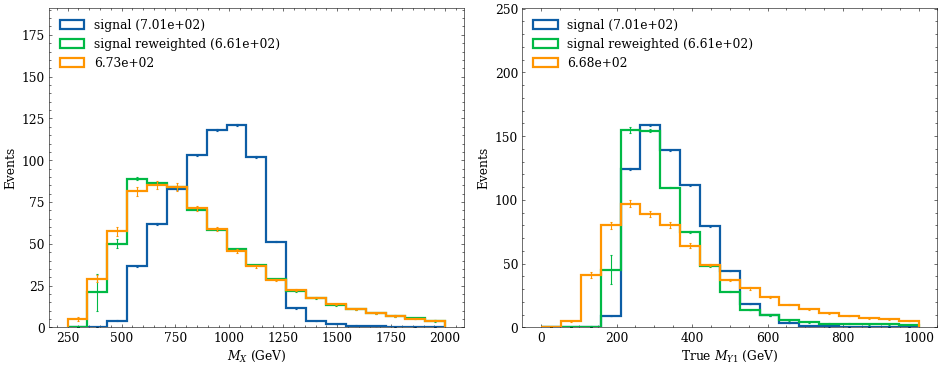

In [21]:
study.quick_region(
    signal, signal, bkg,
    legend=True,
    label=['signal','signal reweighted'],
    scale=[lambda t : 1/33 ]*33 + [lambda t : 1/33 * sig_sf.evaluate(t.X_m)]*33,
    varlist=['X_m','true_y_m[:,0]'],
    xlabels=[None, 'True $M_{Y1}$ (GeV)'],
    binlist=[(250,2000,20),(0,1000,20)],
    lumi=None,
)

100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


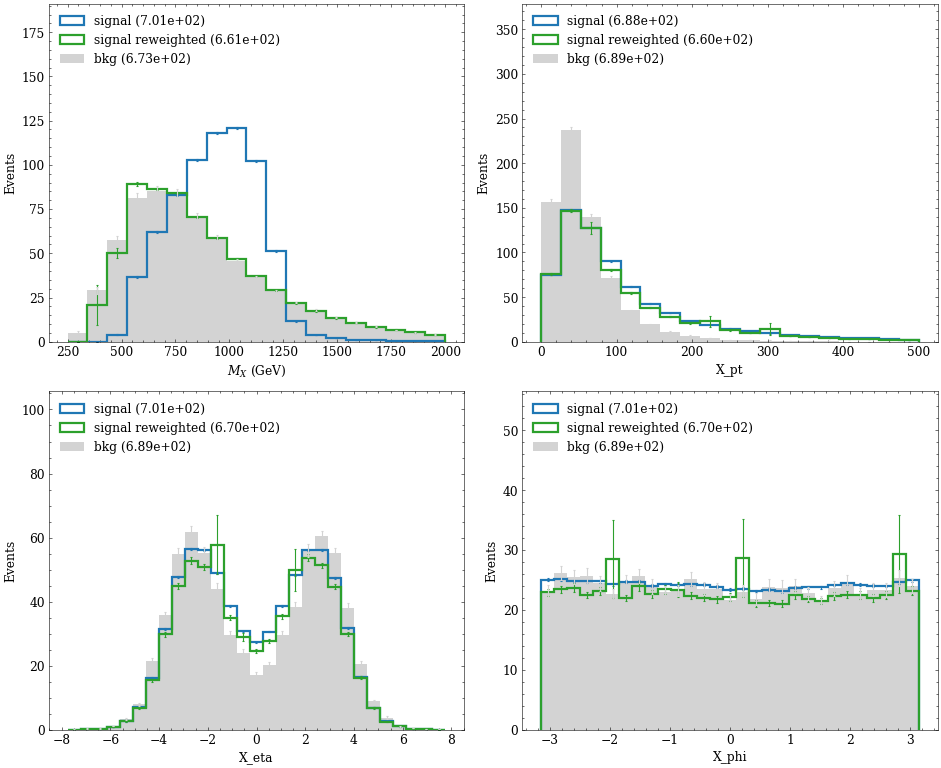

In [18]:
study.quick_region(
    signal, signal, bkg,
    legend=True,
    label=['signal','signal reweighted', 'bkg'],
    h_color=['tab:blue','tab:green', 'lightgrey'],
    h_histtype=['step','step','stepfilled'],
    scale=[lambda t : 1/33 ]*33 + [lambda t : 1/33 * sig_sf.evaluate(t.X_m)]*33,
    varlist=['X_m','X_pt','X_eta','X_phi'],
    binlist=[(250,2000,20),(0,500,20)],
    lumi=None,
)

100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


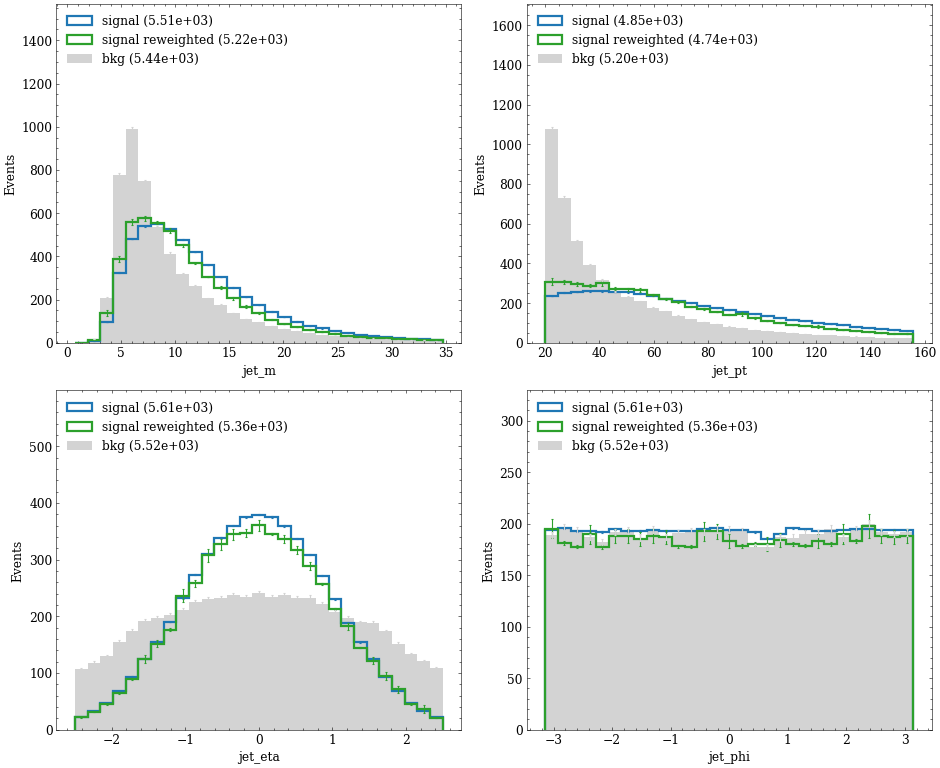

In [19]:
study.quick_region(
    signal, signal, bkg,
    legend=True,
    label=['signal','signal reweighted', 'bkg'],
    h_color=['tab:blue','tab:green', 'lightgrey'],
    h_histtype=['step','step','stepfilled'],
    scale=[lambda t : 1/33 ]*33 + [lambda t : 1/33 * sig_sf.evaluate(t.X_m)]*33,
    varlist=['jet_m','jet_pt','jet_eta','jet_phi'],
    lumi=None,
)